In [1]:
from Supplements import *

In [122]:
dataset = 'loan_data_set.csv'
data = pd.read_csv(dataset, header=0)

processed_output = data_processing(data)
data = processed_output[0]
X = data.iloc[:, 0:data.shape[1] - 1]
X = X.sample(frac = 1)
X.reset_index(inplace=True, drop=True)
y_original = list(data.iloc[:, -1])
scaled_income = processed_output[1].scale_[0] * (5000 - processed_output[1].data_min_[0])

X, y = data_manipulation(X, y_original)
X = X.iloc[:, :2]
X

['Education', 'Self_Employed', 'Gender', 'Property_Area', 'Loan_Status', 'Dependents', 'Married']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


,ApplicantIncome,CoapplicantIncome
0,0.040816,0.061442
1,0.094459,0.000000
2,0.034731,0.085705
3,0.025813,0.000000
4,0.029066,0.000000
...,...,...
475,0.034818,0.168484
476,0.106370,0.123149
477,0.041014,0.035760
478,0.037724,0.066613


In [3]:
scaled_income

0.05998763141620285

In [27]:
class LinearClassificationLearnerLoan(LinearClassificationLearner):

    def __init__(self, verbose=False):
        super().__init__(verbose)
        self.income = 0
        self.alpha = 0

    def add_knowledge_constraints(self, X, y, K=None):
        if K[1] is not None:
            self.income = K[0]
            self.alpha = K[1]
            print('adding knowledge constraint')
            _X = RealVector('_x', X.shape[1])
            self.Hard_Constraints.append(ForAll(_X, Implies(And([_X[0] <= self.income] +
                                                                [And(_X[i] <= 1,
                                                                     _X[i] >= 0)
                                                                 for i in range(X.shape[1])]),
                                                            LinearClassificationLearnerLoan.sumproduct(_X,
                                                                                                       self.W) < 0)))

    def predict(self, X, y, weights=None):
        if weights is None:
            weights = self.W_learnt

        X_1 = X.copy()
        X_1.insert(loc=0, column='intercept', value=[1] * X.shape[0])
        X_1 = X_1[:].values
        confidence = X_1.dot(pd.Series(weights))
        predictions = [1 if c > 0 else 0 for c in confidence]

        predictions_correct = [1 if y[i] == predictions[i] else 0 for i in range(len(predictions))]

        return predictions, sum(predictions_correct), sum(predictions_correct) / len(predictions_correct), confidence

    def calculate_gradient(self, X, y, weights):
        weight_tensors = torch.tensor(weights, requires_grad=True)

        X_1 = X.copy()
        X_1.insert(loc=0, column='intercept', value=[1] * X.shape[0])
        X_1 = X_1[:].values
        X_1 = torch.tensor(X_1)
        h = torch.matmul(X_1, weight_tensors.double())

        Z = [1 / (1 + torch.exp(-h[i])) for i in range(len(y))]
        loss = -sum([torch.log(Z[i] + torch.exp(torch.tensor([-15.0]))) if y[i] == 1 else
                     torch.log(1 - Z[i] + torch.exp(torch.tensor([-15.0])))
                     for i in range(len(y))]) / len(y)
        loss.backward()
        gradients = weight_tensors.grad
        gradients = gradients.detach().cpu().numpy()
        loss = loss.detach().cpu().numpy()

        return gradients, loss.item()

    def calculate_gradient_non_regularized(self, X, y, weights):
        gradient = []
        h = self.predict(X, y, weights=weights)[3]
        Z = [1 / (1 + np.exp(-h[i])) for i in range(len(y))]
        loss = log_loss(y, Z)
        Z_Y = [Z[i] - y[i] for i in range(len(y))]
        gradient.append(sum(Z_Y))
        gradient.extend(list(X.T.dot(Z_Y)))
        gradient = [g / X.shape[0] for g in gradient]
        print(gradient)
        return gradient, loss


In [123]:
model = LinearClassificationLearnerLoan()
model.learn(X, y,
            M=[0, 1],
            epochs=10,
            batch_size=10,
            K=[scaled_income, 0],
            step_size=1, 
            learning_rate=0.1
           )

number of instances being considered: 10
adding knowledge constraint
knowledge constraints added, learning rate 0.1
starting the check
found unsat
size of core: 3
found unsat
size of core: 4
found unsat
size of core: 2
found unsat
size of core: 3
found unsat
size of core: 8
found unsat
size of core: 7
found unsat
size of core: 2
found sat
learned parameters
[-0.6666488708558005, 8.632747851155838, -15.545154528518724]
gradient: [-0.3781203  -0.01738306 -0.0256189 ]
runtime: 0.18563032150268555
training accuracy: 0.35208333333333336
number of instances being considered: 10
adding knowledge constraint
knowledge constraints added, learning rate 0.1
[-1, -1, -1]
starting the check
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found unsat
size of core: 1
found 

In [124]:
model.all_weights

[[-0.6666488708558005, 8.632747851155838, -15.545154528518724],
 [-0.5666488708558005, 8.718924522120544, -15.445154528518724],
 [-0.5454733843568103, 8.740100008619534, -15.345154528518725],
 [-0.5378850226781252, 8.840100008619533, -15.245154528518725],
 [-0.5342013298428103, 8.843783701454848, -15.145154528518725],
 [-0.5324131187005996, 8.845571912597059, -15.045154528518726],
 [-0.5315450498273019, 8.846439981470358, -14.945154528518726],
 [-0.5311236546402343, 8.846861376657426, -14.845154528518727],
 [-0.5309190926415888, 8.84706593865607, -14.844949966520081],
 [-0.5308197901042696, 8.84716524119339, -14.744949966520082],
 [-0.5307715846996328, 8.847213446598026, -14.744901761115445],
 [-0.5307481838772679, 8.84723684742039, -14.644901761115445],
 [-0.5307368241865551, 8.847248207111102, -14.544901761115446],
 [-0.5307313097404781, 8.847253721557179, -14.544896246669369],
 [-0.530728632808834, 8.847256398488824, -14.44489624666937],
 [-0.530727333319651, 8.847257697978007, -14.

In [70]:
def check_satisfaction(w, X, K=None):
    s = Solver()
    x = RealVector('_x', X.shape[1])
    s.add(x[0] <= K[0])
    s.add(And([And(x[i] <= 1, x[i] >= 0) for i in range(X.shape[1])]))
    s.add(LinearClassificationLearnerLoan.sumproduct(x, w) >= 0)
    m = s.check()
    if m == sat:
        return 'Does Not Satisfy'
    else:
        return 'Satisfies'

In [77]:
for w in model.all_weights:
    print(check_satisfaction(model.all_weights[0], X, K=[scaled_income, 0]))

Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies
Satisfies


KeyboardInterrupt: 

In [74]:
def add_weight_constraints(s, W, W_learned, margin=0.01):
    if len(W_learned) == 0:
        s.add([And(w <= 100, w >= -100) for w in W])
    else:
        s.add([And(w <= 100, w >= -100) for w in W])
        s.add(Or([Or(W[j] <= W_learned[j] - margin, W[j] >= W_learned[j] + margin) for j in range(len(W))]))

In [149]:
from z3 import *
s = Solver()

all_weights = []
W_learned = []
for i in range(100000):
    W = RealVector('w', X.shape[1] + 1)
    
    add_weight_constraints(s, W, W_learned, margin=5)
    
    _X = RealVector('_x', X.shape[1])
    s.add(ForAll(_X, Implies(And([_X[0] <= scaled_income] + 
                                 [And(_X[i] <= 1, _X[i] >= 0) for i in range(X.shape[1])]), 
                             LinearClassificationLearnerLoan.sumproduct(_X, W) < 0)))
    if s.check() == sat:
        W_learned = [s.model()[w].numerator_as_long()/s.model()[w].denominator_as_long() for w in W]
        print(W_learned)
        all_weights.append(W_learned)
    else:
        raise ValueError('Found Unsat/Unknown')

[-99.0, -99.0, -99.0]
[-1.0, 0.0, -87.64]
[-6.0, 0.0, -74.4115]
[-6.0, 0.0, -79.4115]
[-6.0, -5.0, -79.4115]
[-1.0, -5.0, -79.4115]
[-11.0, -5.0, -79.4115]
[-11.0, -5.0, -74.4115]
[-11.0, -5.0, -69.4115]
[-11.0, -10.0, -69.4115]
[-6.0, -10.0, -69.4115]
[-16.0, -10.0, -69.4115]
[-16.0, -10.0, -64.4115]
[-16.0, -10.0, -59.411500000000004]
[-16.0, -10.0, -54.411500000000004]
[-16.0, -10.0, -49.411500000000004]
[-16.0, -10.0, -44.411500000000004]
[-16.0, -10.0, -39.411500000000004]
[-16.0, -10.0, -34.411500000000004]
[-16.0, -10.0, -29.411500000000004]
[-16.0, -10.0, -24.411500000000004]
[-16.0, -10.0, -19.411500000000004]
[-16.0, -10.0, -14.411500000000004]
[-16.0, -10.0, -9.411500000000004]
[-16.0, -10.0, -4.411500000000004]
[-16.0, -10.0, 0.5884999999999962]
[-16.0, -10.0, 5.588499999999996]
[-16.0, -10.0, 10.588499999999996]
[-16.0, -10.0, 15.588499999999996]
[-21.588499999999996, -5.0, 20.588499999999996]
[-16.588499999999996, -5.0, 15.588499999999996]
[-11.0, -5.0, 10.588499999999996

ValueError: Found Unsat/Unknown

In [154]:
len(all_weights)

21571

In [22]:
import matplotlib.pyplot as plt

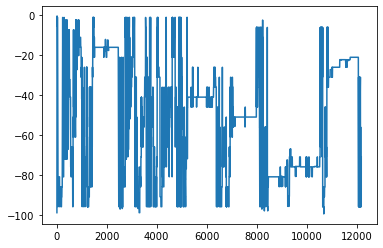

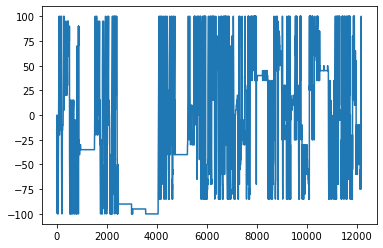

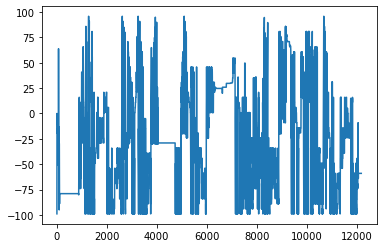

In [89]:
for j in range(len(all_weights[0])):
    x = list(map(lambda x:x[j], all_weights))
    plt.figure()
    plt.plot(x)
    plt.show()

In [24]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

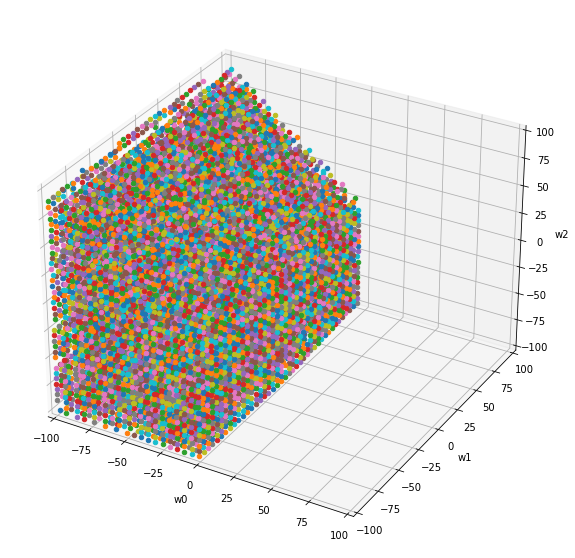

In [155]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

for params in all_weights:
    ax.scatter(params[0], params[1], params[2])

ax.set_xlabel("w0")

ax.set_ylabel("w1")

ax.set_zlabel("w2")

ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)

plt.show()

In [159]:
check_satisfaction([0, -50, -50], X, K=[scaled_income, 0])

'Does Not Satisfy'

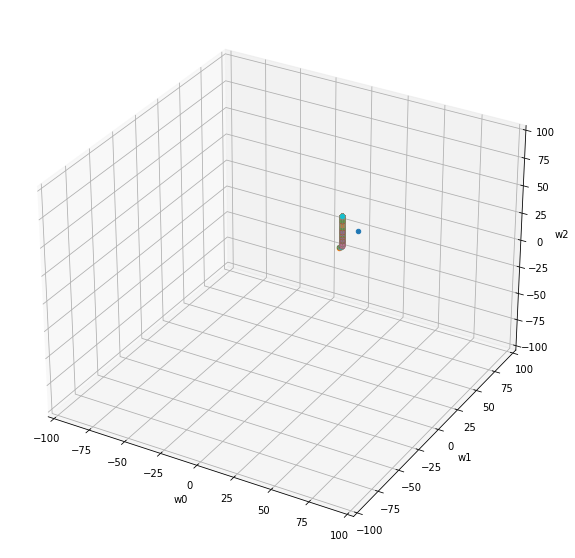

In [95]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

for params in model.all_weights:
    ax.scatter(params[0], params[1], params[2])

ax.set_xlabel("w0")

ax.set_ylabel("w1")

ax.set_zlabel("w2")

ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)

plt.show()

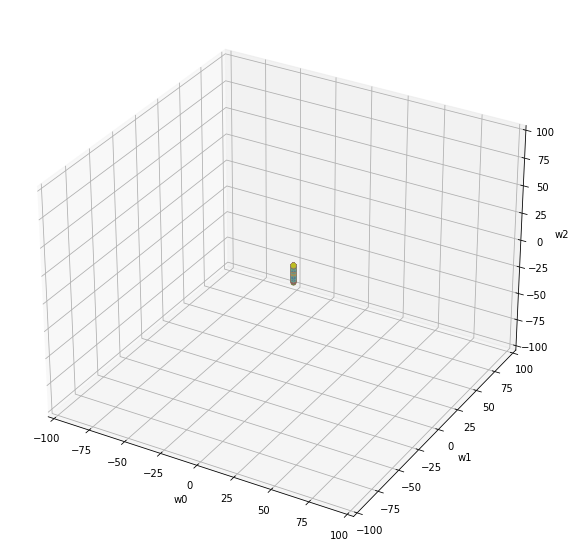

In [153]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

for params in model.all_weights:
    ax.scatter(params[0], params[1], params[2])

ax.set_xlabel("w0")

ax.set_ylabel("w1")

ax.set_zlabel("w2")

ax.set_xlim3d(-100, 100)
ax.set_ylim3d(-100, 100)
ax.set_zlim3d(-100, 100)

plt.show()